Towards the end of this exercise, we're presented with following graphs.

1.What matters to the customers when they shortlist the rentals? They look for cleanliness, Checking, communication and location.

2.Neighbourhood vs prices. When a customer browse through the website, they are more likely to choose the neighbour hood which are close to the city center but generally, these properties are more expensive than the ones which are far from city center.

3. Property Type vs. Prices has a strong correlation as shown in the graph.

4. Next, the "features" such as Heating, TV, Wi-Fi are common features. Which property owners must pay attention to. Any compromise on any of these amenities may affect customers.

5. Lastly, I've tried to generate a graph of prices using latitude/longitude vs. price. It clearly shows some locations are more expensive.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from IPython import display
import collections
from time import time
from itertools import chain
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
import seaborn as sns
import qgrid
import datetime
import sympy as S
import scipy

df_listings = pd.read_csv("../seattlelistings.csv")
df_calendar = pd.read_csv("../seattlecalendar.csv")
df_reviews = pd.read_csv("../seattlereviews.csv")

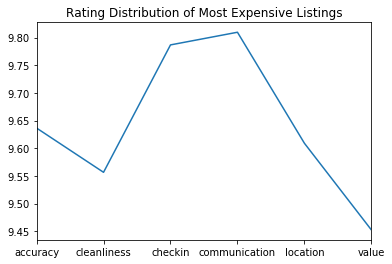

In [3]:
df_listings = df_listings.rename(columns = {'review_scores_accuracy': 'accuracy', 
                                    'review_scores_cleanliness': 'cleanliness', 
                                    'review_scores_checkin': 'checkin',
                                    'review_scores_communication':'communication',
                                    'review_scores_location':'location',
                                    'review_scores_value': 'value'})
high_price = df_listings[['accuracy',
               'cleanliness',
               'checkin',
               'communication',
               'location',
               'value']].mean()
high_price.plot(kind = 'line', title = 'Rating Distribution of Most Expensive Listings' )

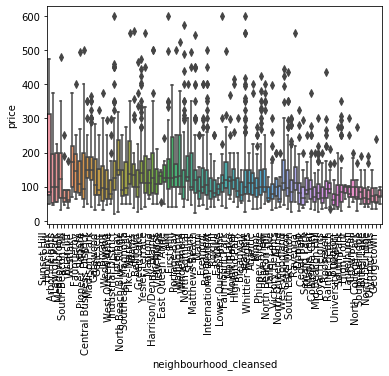

In [17]:
df_listings['price']=df_listings['price'].replace('[\$,]', '', regex=True).astype(float)
sort_price = df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 80)]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.xticks(rotation=90)
plt.savefig('neighbourhood_prices.pdf')
plt.show();

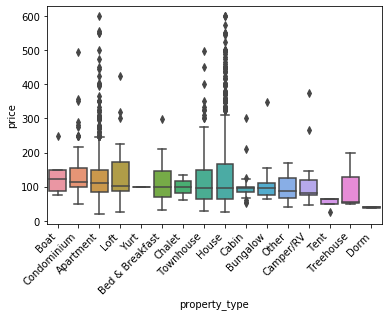

In [13]:
sort_price = df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)]\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='property_type', data=df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

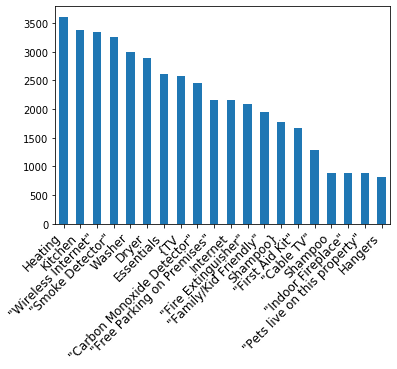

In [14]:
pd.Series(np.concatenate(df_listings['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

In [18]:
df_calendar_clean=df_calendar.drop(columns='price')
df_calendar_clean.rename(columns={'listing_id': 'id'},inplace=True)

df_listings_location=df_listings[['id','neighbourhood_cleansed','price', 'latitude', 'longitude']]

df_listings_location['price']=df_listings_location['price'].replace('[\$,]', '', regex=True).astype(float)
df_listings_location.groupby('neighbourhood_cleansed')['price'].mean()

df_listings_price = df_listings_location[['id','price','neighbourhood_cleansed', 'latitude', 'longitude']]

df_merged = pd.merge(df_calendar_clean, df_listings_price, how='left', on=['id'])

df_unavailable = df_merged[df_merged['available']=='f']

df_mean = df_unavailable.groupby([df_unavailable['neighbourhood_cleansed']]).mean()
df_count = df_unavailable.groupby([df_unavailable['neighbourhood_cleansed']]).count()

df_neighbourhood = pd.merge(df_mean, df_count, how='left', on=['neighbourhood_cleansed'])

df_neighbourhood.drop(columns=['id_x', 'date', 'available', 'price_y', 'latitude_y', 'longitude_y'], inplace=True)
df_neighbourhood.rename(columns={'price_x': 'price', 'latitude_x': 'latitude', 'longitude_x': 'longitude', 'id_y': 'count'}, inplace=True)
df_neighbourhood['neighbourhood'] = df_neighbourhood.index

/home/vinay/miniconda3/envs/udacity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
df_mean

,id,price,latitude,longitude
neighbourhood_cleansed,,,,
Adams,5.542830e+06,115.133884,47.671330,-122.386220
Alki,6.202881e+06,153.413006,47.575449,-122.408852
Arbor Heights,6.632384e+06,95.655172,47.510262,-122.379525
Atlantic,6.412704e+06,104.067875,47.594873,-122.305617
Belltown,5.982714e+06,164.992521,47.615280,-122.346224
...,...,...,...,...
West Woodland,4.943752e+06,147.255884,47.669175,-122.366139
Westlake,7.522048e+06,146.279735,47.630573,-122.342493
Whittier Heights,5.102045e+06,140.031389,47.683371,-122.371390


Text(0.5, 1.0, 'Seattle Airbnb Prices')

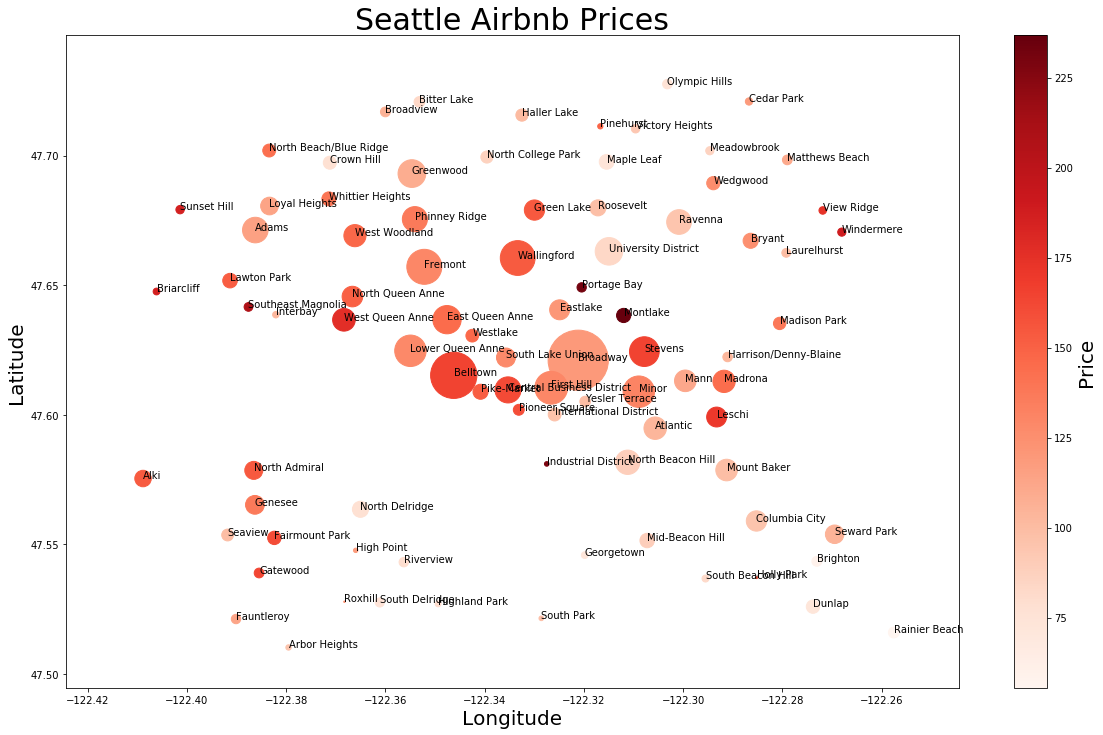

In [7]:
lon = df_neighbourhood['longitude'].values
lat = df_neighbourhood['latitude'].values
price = df_neighbourhood['price'].values
count = df_neighbourhood['count'].values
neighbourhood = df_neighbourhood['neighbourhood'].values

fig, ax = plt.subplots(figsize=(20, 12))
plt.scatter(lon, lat, c=price, s=count/15, cmap='Reds', label=neighbourhood)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)

cbar = plt.colorbar()
cbar.ax.set_ylabel('Price', fontsize=20)

plt.clim=(3,7)
for i, txt in enumerate(neighbourhood):
    plt.annotate(txt, (lon[i], lat[i]))
plt.title('Seattle Airbnb Prices', fontsize=30)